**Importing the required libraries**

In [ ]:
import os, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as random
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

**Now assigning path names to variables**

In [ ]:
origial_dataset_dir = '/kaggle/input/dogs-vs-cats/train/train'
base_dir = '/kaggle/working/'

In [ ]:
# Create train, validation and test folder
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Create folders
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

In [ ]:
# creating the training folder
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_cats_dir)
os.mkdir(train_dogs_dir)
#creating the validation folder
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_cats_dir)
os.mkdir(validation_dogs_dir)
#creating the test folder
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_cats_dir)
os.mkdir(test_dogs_dir)

#### Copy cats image

In [5]:
# Copy 1000 cats image to train/cats
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames :
    src = os.path.join(origial_dataset_dir, fname)
    dts = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dts)

# Copy 500 cats image to validatinon/cats
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames :
    src = os.path.join(origial_dataset_dir, fname)
    dts = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dts)

# Copy 500 cats image to test/cats
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames :
    src = os.path.join(origial_dataset_dir, fname)
    dts = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dts)

#### Copy dogs image

In [6]:
# Copy 1000 dogs image to train/cats
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames :
    src = os.path.join(origial_dataset_dir, fname)
    dts = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dts)

# Copy 500 dogs image to validatinon/cats
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames :
    src = os.path.join(origial_dataset_dir, fname)
    dts = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dts)

# Copy 500 dogs image to test/cats
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames :
    src = os.path.join(origial_dataset_dir, fname)
    dts = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dts)

Summarising the no of images in each folder

In [7]:
print('Total training cat images : ', len(os.listdir(train_cats_dir)))
print('Total validation cat images : ', len(os.listdir(validation_cats_dir)))
print('Total test cat images : ', len(os.listdir(test_cats_dir)))
print('_' * 45)
print('Total training dog images : ', len(os.listdir(train_dogs_dir)))
print('Total validation dog images : ', len(os.listdir(validation_dogs_dir)))
print('Total test dog images : ', len(os.listdir(test_dogs_dir)))

Total training cat images :  1000
Total validation cat images :  500
Total test cat images :  500
_____________________________________________
Total training dog images :  1000
Total validation dog images :  500
Total test dog images :  500


**MODEL**

**Now definig the 'base' with the vgg16 model**

In [8]:
base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

58889256/58889256 [==============================] - 0s 0us/step


**Now I am going to use fine tune approach to the classification of cats and dogs**

In [9]:
# creating the model by extending vgg16
model = models.Sequential()
model.add(base)
# now adding the flatten layer
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
# adding the output layer which maps from 512 neurons to the singe neuron as it is a binary classification 
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
#printing the base layer which has the vgg16 model
for layer in base.layers :
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [11]:
base.trainable = True
set_trainable = False

for layer in base.layers :
    if layer.name == 'block5_conv1' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

Data generators for training and validation

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, # target directory
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
# Compile
# using root mean square propagation as the optimizer
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5), 
              loss='binary_crossentropy', 
              metrics=['acc']
             )

# printing the summary of each epoches
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 16s 145ms/step - loss: 0.3015 - acc: 0.8730 - val_loss: 0.2820 - val_acc: 0.8890
Epoch 2/30
100/100 [==============================] - 15s 145ms/step - loss: 0.2739 - acc: 0.8860 - val_loss: 0.3740 - val_acc: 0.8540
Epoch 3/30
100/100 [==============================] - 14s 142ms/step - loss: 0.2717 - acc: 0.8840 - val_loss: 0.3164 - val_acc: 0.8820
Epoch 4/30
100/100 [==============================] - 14s 142ms/step - loss: 0.2597 - acc: 0.8885 - val_loss: 0.2686 - val_acc: 0.9000
Epoch 5/30
100/100 [==============================] - 14s 142ms/step - loss: 0.2427 - acc: 0.8970 - val_loss: 0.2787 - val_acc: 0.8920
Epoch 6/30
100/100 [==============================] - 14s 143ms/step - loss: 0.2478 - acc: 0.9000 - val_loss: 0.2705 - val_acc: 0.8980
Epoch 7/30
100/100 [==============================] - 14s 143ms/step - loss: 0.2205 - acc: 0.9045 - val_loss: 0.3115 - val_acc: 0.8820
Epoch 8/30
100/100 [==============================] - 1

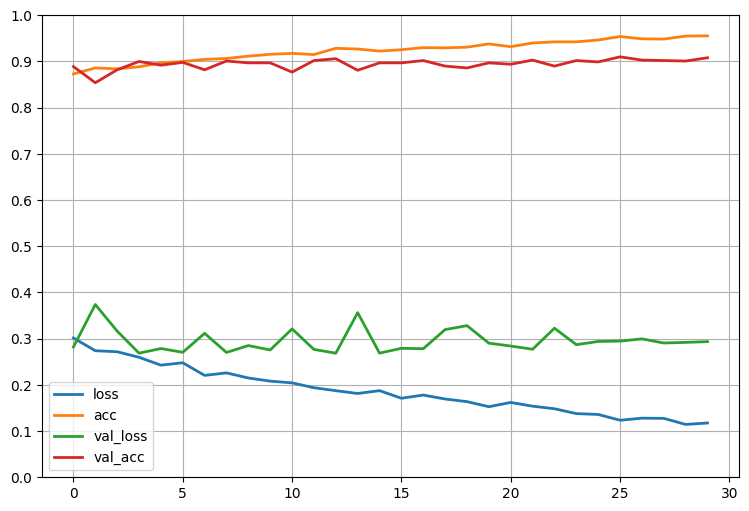

In [21]:
# plotting the curve of the model which shows the train and validation accuracy and errors
pd.DataFrame(history.history).plot(figsize=(9, 6), linewidth=2)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.show()

In [23]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc : ', test_loss)
print('test loss : ', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 2s 33ms/step - loss: 0.3263 - acc: 0.8990
test acc :  0.326331228017807
test loss :  0.8989999890327454


**Now lets make prediction on a image of dog**

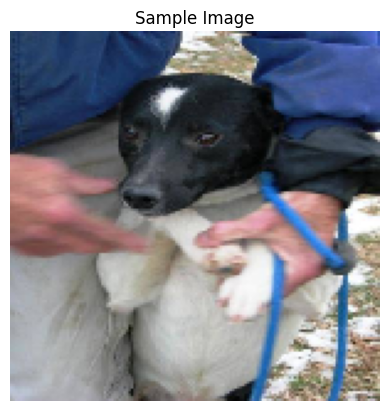

1/1 [==============================] - 0s 389ms/step
The image is predicted to be a Dog with probability 1.00


In [26]:
# importing the image module
from tensorflow.keras.preprocessing import image

# function to preprocess the image ie to reshape the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150)) 
    
    # displaying image
    plt.imshow(img)
    plt.axis('off') 
    plt.title('Sample Image')
    plt.show()
    
    # converting image to array as model on takes numeric values as inputs
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255.0  # Rescale to [0, 1]
    
    return img_array

# Function to make prediction
def predict_sample_image(model, img_path):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)

    # Print the prediction result
    if prediction < 0.5:
        print(f"The image is predicted to be a Cat with probability {1 - prediction[0][0]:.2f}")
    else:
        print(f"The image is predicted to be a Dog with probability {prediction[0][0]:.2f}")

sample_image_path = '/kaggle/input/dogs-vs-cats/test/test/1.jpg' 

predict_sample_image(model, sample_image_path)